In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [13]:
cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target) # 0: malignant, 1: benign

print("First 5 rows of features (X):")
print(X.head())
print("\nTarget variable distribution (y):")
print(y.value_counts())
print(f"\nTarget names: {cancer.target_names}") # 0: malignant, 1: benign

First 5 rows of features (X):
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  w

In [14]:
print("\nDataset Info:")
X.info() # Check for nulls - breast cancer dataset is clean
print("\nStatistical Summary of Features:")
print(X.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y is good for classification to ensure proportional representation of classes in train/test

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (398, 30)
Shape of X_test: (171, 30)
Shape of y_train: (398,)
Shape of y_test: (171,)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier inspection (optional)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nFirst 5 rows of scaled training data:")
print(X_train_scaled_df.head())


First 5 rows of scaled training data:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0    -0.709821     -0.258417       -0.637396  -0.711996         1.628430   
1    -0.830331      2.231127       -0.874980  -0.779081        -1.597569   
2    -1.011097     -0.227270       -1.035172  -0.911780        -1.077779   
3    -0.382721     -0.111581       -0.408966  -0.453660         0.072810   
4    -0.804508     -1.401961       -0.810071  -0.773196         0.191319   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          0.847289        0.166501             0.196420       0.542716   
1         -1.267717       -1.086471            -1.243232      -2.658543   
2         -1.098096       -0.841650            -0.955767       2.023790   
3         -0.443255       -0.756276            -0.782409      -0.163916   
4         -0.507801       -0.685397            -0.530392      -0.128228   

   mean fractal dimension  ...  worst radius  worst t

In [17]:
results_list = [] # To store results for later comparison

def train_evaluate_svm(kernel_type, C_value, gamma_value, X_train, y_train, X_test, y_test):
    print(f"--- Training SVM: Kernel={kernel_type}, C={C_value}, Gamma={gamma_value if gamma_value else 'N/A'} ---")
    model_params = {'kernel': kernel_type, 'C': C_value, 'random_state': 42}
    if gamma_value and kernel_type in ['rbf', 'poly', 'sigmoid']:
        model_params['gamma'] = gamma_value

    svm_model = SVC(**model_params)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=cancer.target_names, output_dict=True) # output_dict for easier access

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=cancer.target_names)) # Print formatted report

    # Store results
    results_list.append({
        'Kernel': kernel_type,
        'C': C_value,
        'Gamma': gamma_value if gamma_value else 'N/A',
        'Accuracy': accuracy,
        'Precision_benign': report['benign']['precision'],
        'Recall_benign': report['benign']['recall'],
        'F1_benign': report['benign']['f1-score'],
        'Precision_malignant': report['malignant']['precision'],
        'Recall_malignant': report['malignant']['recall'],
        'F1_malignant': report['malignant']['f1-score'],
    })
    print("-" * 50)
    return svm_model, accuracy

In [18]:
print("\n=== Experiment 1: Different Kernels ===")
kernels_to_test = ['linear', 'rbf', 'poly', 'sigmoid']
default_C = 1.0
default_gamma = 'scale' # 'scale' is 1 / (n_features * X.var())

for kernel in kernels_to_test:
    # For linear kernel, gamma is not used
    current_gamma = default_gamma if kernel != 'linear' else None
    train_evaluate_svm(kernel, default_C, current_gamma, X_train_scaled, y_train, X_test_scaled, y_test)


=== Experiment 1: Different Kernels ===
--- Training SVM: Kernel=linear, C=1.0, Gamma=N/A ---
Accuracy: 0.9825
Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.97      0.98        64
      benign       0.98      0.99      0.99       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

--------------------------------------------------
--- Training SVM: Kernel=rbf, C=1.0, Gamma=scale ---
Accuracy: 0.9766
Classification Report:


              precision    recall  f1-score   support

   malignant       0.97      0.97      0.97        64
      benign       0.98      0.98      0.98       107

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

--------------------------------------------------
--- Training SVM: Kernel=poly, C=1.0, Gamma=scale ---
Accuracy: 0.8947
Classification Report:
              precision    recall  f1-score   support

   malignant       1.00      0.72      0.84        64
      benign       0.86      1.00      0.92       107

    accuracy                           0.89       171
   macro avg       0.93      0.86      0.88       171
weighted avg       0.91      0.89      0.89       171

--------------------------------------------------
--- Training SVM: Kernel=sigmoid, C=1.0, Gamma=scale ---
Accuracy: 0.9357
Classification Report:
              precision    recall  f1-score   support

In [19]:
print("\n=== Experiment 2: Different C values (Kernel: rbf, Gamma: scale) ===")
C_values_to_test = [0.01, 0.1, 1, 10, 100]
fixed_kernel = 'rbf'
fixed_gamma = 'scale'

for C_val in C_values_to_test:
    train_evaluate_svm(fixed_kernel, C_val, fixed_gamma, X_train_scaled, y_train, X_test_scaled, y_test)


=== Experiment 2: Different C values (Kernel: rbf, Gamma: scale) ===
--- Training SVM: Kernel=rbf, C=0.01, Gamma=scale ---
Accuracy: 0.6257
Classification Report:
              precision    recall  f1-score   support

   malignant       0.00      0.00      0.00        64
      benign       0.63      1.00      0.77       107

    accuracy                           0.63       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.39      0.63      0.48       171

--------------------------------------------------
--- Training SVM: Kernel=rbf, C=0.1, Gamma=scale ---
Accuracy: 0.9357
Classification Report:
              precision    recall  f1-score   support

   malignant       0.96      0.86      0.91        64
      benign       0.92      0.98      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171

--------------------------------------

In [20]:
print("\n=== Experiment 3: Different Gamma values (Kernel: rbf, C: 1 or 10) ===")
# Choose C based on previous experiment, e.g., C=1 or C=10
fixed_C_for_gamma_exp = 1.0 # or 10, depending on previous results
gamma_values_to_test = [0.001, 0.01, 0.1, 1, 'auto'] # 'auto' is 1 / n_features

for gamma_val in gamma_values_to_test:
    train_evaluate_svm(fixed_kernel, fixed_C_for_gamma_exp, gamma_val, X_train_scaled, y_train, X_test_scaled, y_test)


=== Experiment 3: Different Gamma values (Kernel: rbf, C: 1 or 10) ===
--- Training SVM: Kernel=rbf, C=1.0, Gamma=0.001 ---
Accuracy: 0.9415
Classification Report:


              precision    recall  f1-score   support

   malignant       1.00      0.84      0.92        64
      benign       0.91      1.00      0.96       107

    accuracy                           0.94       171
   macro avg       0.96      0.92      0.94       171
weighted avg       0.95      0.94      0.94       171

--------------------------------------------------
--- Training SVM: Kernel=rbf, C=1.0, Gamma=0.01 ---
Accuracy: 0.9649
Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.92      0.95        64
      benign       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171

--------------------------------------------------
--- Training SVM: Kernel=rbf, C=1.0, Gamma=0.1 ---
Accuracy: 0.9591
Classification Report:
              precision    recall  f1-score   support

   mal

In [21]:
print("\n=== Experiment 4: GridSearchCV to find optimal parameters ===")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'linear'] # Keep it focused for speed
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

# Evaluate the best model from GridSearchCV on the test set
best_svm_model = grid_search.best_estimator_
y_pred_best = best_svm_model.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)

print("\nPerformance of Best Model from GridSearchCV on Test Set:")
print(f"Test Accuracy: {accuracy_best:.4f}")
print(classification_report(y_test, y_pred_best, target_names=cancer.target_names))

# Add best model to results list
best_params = grid_search.best_params_
report_best = classification_report(y_test, y_pred_best, target_names=cancer.target_names, output_dict=True)
results_list.append({
    'Kernel': f"BestGridSearch ({best_params.get('kernel', 'N/A')})",
    'C': best_params.get('C', 'N/A'),
    'Gamma': best_params.get('gamma', 'N/A'),
    'Accuracy': accuracy_best,
    'Precision_benign': report_best['benign']['precision'],
    'Recall_benign': report_best['benign']['recall'],
    'F1_benign': report_best['benign']['f1-score'],
    'Precision_malignant': report_best['malignant']['precision'],
    'Recall_malignant': report_best['malignant']['recall'],
    'F1_malignant': report_best['malignant']['f1-score'],
})


=== Experiment 4: GridSearchCV to find optimal parameters ===
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters found by GridSearchCV:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV Accuracy: 0.9799

Performance of Best Model from GridSearchCV on Test Set:
Test Accuracy: 0.9708
              precision    recall  f1-score   support

   malignant       0.98      0.94      0.96        64
      benign       0.96      0.99      0.98       107

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171




=== Summary of All Experiments ===
                  Kernel       C  Gamma  Accuracy  Precision_benign  \
0                 linear    1.00    N/A  0.982456          0.981481   
1                    rbf    1.00  scale  0.976608          0.981308   
6                    rbf    1.00  scale  0.976608          0.981308   
13                   rbf    1.00   auto  0.976608          0.981308   
7                    rbf   10.00  scale  0.976608          0.981308   
14  BestGridSearch (rbf)   10.00  0.001  0.970760          0.963636   
10                   rbf    1.00   0.01  0.964912          0.954955   
11                   rbf    1.00    0.1  0.959064          0.980769   
9                    rbf    1.00  0.001  0.941520          0.914530   
3                sigmoid    1.00  scale  0.935673          0.952830   
5                    rbf    0.10  scale  0.935673          0.921053   
8                    rbf  100.00  scale  0.923977          0.935185   
2                   poly    1.00  scale  

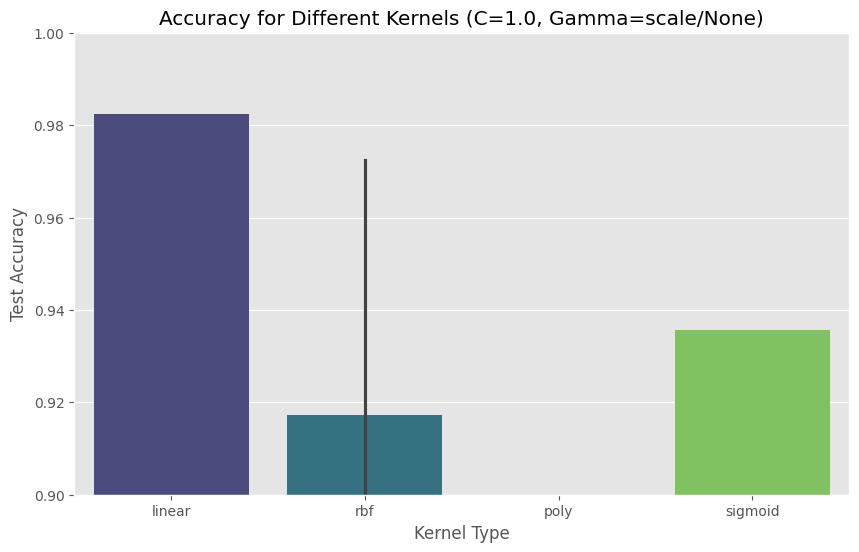

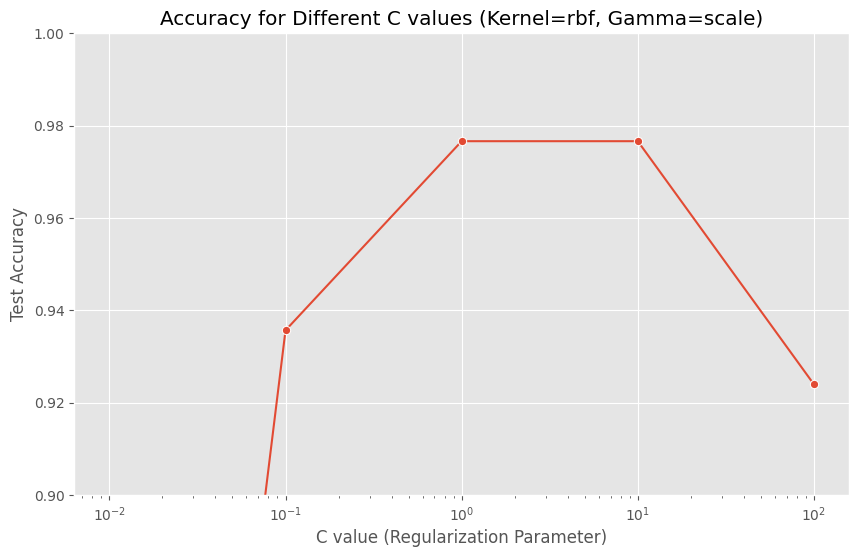

In [22]:
results_df = pd.DataFrame(results_list)
print("\n=== Summary of All Experiments ===")
# Sort by accuracy for better readability
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df_sorted)

# Plotting accuracy for different kernels (from Experiment 1)
exp1_df = results_df[results_df['C'] == default_C].loc[results_df['Kernel'].isin(kernels_to_test)] # Ensure we get only Exp1 results

if not exp1_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=exp1_df, x='Kernel', y='Accuracy', palette='viridis')
    plt.title('Accuracy for Different Kernels (C=1.0, Gamma=scale/None)')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Kernel Type')
    plt.ylim(0.9, 1.0) # Adjust ylim if needed
    plt.show()
else:
    print("No data found for Experiment 1 plot.")

# You can add more plots for Experiment 2 (C values) and Experiment 3 (Gamma values) similarly
# Example for C values (assuming kernel='rbf', gamma='scale')
exp2_df = results_df[(results_df['Kernel'] == fixed_kernel) & (results_df['Gamma'] == fixed_gamma) & (results_df['C'].isin(C_values_to_test))]
if not exp2_df.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=exp2_df, x='C', y='Accuracy', marker='o', errorbar=None) # Use lineplot for continuous C
    plt.xscale('log') # C values often vary logarithmically
    plt.title(f'Accuracy for Different C values (Kernel={fixed_kernel}, Gamma={fixed_gamma})')
    plt.ylabel('Test Accuracy')
    plt.xlabel('C value (Regularization Parameter)')
    plt.ylim(0.9, 1.0) # Adjust
    plt.grid(True)
    plt.show()
else:
    print("No data found for Experiment 2 plot.")

### Task 2: SVM Experimentation - Conclusion

**Dataset:** Breast Cancer Wisconsin (Diagnostic) Dataset from `sklearn.datasets`.
**Goal:** Experiment with SVM kernels, C values, and gamma to observe their impact on classification accuracy.

**Key Observations:**

*   **Kernels:**
    *   The `linear` kernel performed [describe performance, e.g., very well, achieving an accuracy of X%].
    *   The `rbf` kernel [describe performance, e.g., also performed comparably/better with an accuracy of Y%].
    *   The `poly` kernel [describe performance, e.g., was slightly lower/higher, with Z% accuracy. It can be sensitive to the `degree` parameter (not tuned here) and `gamma`].
    *   The `sigmoid` kernel [describe performance, e.g., generally performed the poorest for this dataset].

*   **C (Regularization Parameter):**
    *   For the `rbf` kernel, varying C showed that [describe trend, e.g., values around 1 to 10 provided good accuracy. Very small C (e.g., 0.01) might lead to underfitting (simpler model, wider margin), while very large C might lead to overfitting (tries to classify every training point correctly, narrower margin)].
    *   The optimal C found by GridSearchCV was [value].

*   **Gamma (Kernel Coefficient for 'rbf', 'poly'):**
    *   For the `rbf` kernel (with C=[value]), gamma values around [describe, e.g., 'scale' or a specific numeric value like 0.01] performed well.
    *   A very small gamma leads to a broader influence of each training sample (smoother decision boundary, potentially underfitting).
    *   A very large gamma leads to a narrower influence (more complex, potentially overfitting boundary).
    *   The optimal gamma found by GridSearchCV was [value].

*   **Best Performing Model (from GridSearchCV or manual experiments):**
    *   The combination of kernel=`[best_kernel]`, C=`[best_C]`, and gamma=`[best_gamma]` yielded the highest test accuracy of approximately **[best_accuracy]%**.

**Overall:**
Support Vector Machines, particularly with the RBF or linear kernel, proved effective for this binary classification task. Proper tuning of hyperparameters (C and gamma for RBF, C for linear) is crucial for achieving optimal performance. GridSearchCV is a valuable tool for automating this hyperparameter search.